In [1]:
import tensorflow as tf, sys
print('Python:', sys.version)
print('TF:', tf.__version__)
print('GPUs:', tf.config.list_physical_devices('GPU'))

Python: 3.11.14 (main, Oct 21 2025, 18:27:30) [Clang 20.1.8 ]
TF: 2.16.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from pathlib import Path
import gzip, numpy as np

DATA_DIR = Path.cwd() / "data" / "fashion"

FILES = {
    "train_images": DATA_DIR / "train-images-idx3-ubyte.gz",
    "train_labels": DATA_DIR / "train-labels-idx1-ubyte.gz",
    "test_images":  DATA_DIR / "t10k-images-idx3-ubyte.gz",
    "test_labels":  DATA_DIR / "t10k-labels-idx1-ubyte.gz",
}

DTYPE_MAP = {
    0x08: np.uint8,  # unsigned byte
    0x09: np.int8,
    0x0B: np.int16,
    0x0C: np.int32,
    0x0D: np.float32,
    0x0E: np.float64,
}

def read_idx_gz(path: Path):
    with gzip.open(path, "rb") as f:
        m = f.read(4)
        if len(m) != 4:
            raise ValueError("Bad IDX header length")
        zero1, zero2, dtype_code, ndim = m
        if zero1 != 0 or zero2 != 0:
            raise ValueError("Not an IDX file (leading zeros missing)")
        if dtype_code not in DTYPE_MAP:
            raise ValueError(f"Unsupported IDX dtype: 0x{dtype_code:02X}")
        shape = tuple(int.from_bytes(f.read(4), "big") for _ in range(ndim))
        buf = f.read()
    arr = np.frombuffer(buf, dtype=DTYPE_MAP[dtype_code]).reshape(shape)
    return arr

# Load locally
x_train = read_idx_gz(FILES["train_images"])  # -> (60000, 28, 28)
y_train = read_idx_gz(FILES["train_labels"])  # -> (60000,)
x_test  = read_idx_gz(FILES["test_images"])   # -> (10000, 28, 28)
y_test  = read_idx_gz(FILES["test_labels"])   # -> (10000,)

print("Loaded:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)


Loaded: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
# split + normalize
val_ratio = 0.1
n_val = int(len(x_train) * val_ratio)
x_val, y_val = x_train[-n_val:], y_train[-n_val:]
x_train, y_train = x_train[:-n_val], y_train[:-n_val]

def prep(x): return (x.astype("float32")/255.0)[..., None]
x_train, x_val, x_test = map(prep, [x_train, x_val, x_test])


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# splits already exist: x_train, y_train, x_val, y_val, x_test, y_test
BATCH = 128
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(4096).batch(BATCH).prefetch(AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val,   y_val  )).batch(BATCH).prefetch(AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((x_test,  y_test )).batch(BATCH).prefetch(AUTOTUNE)

class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"]


2025-11-04 14:27:09.928800: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-04 14:27:09.928832: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-04 14:27:09.928838: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-04 14:27:09.928884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-04 14:27:09.928898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
def build_ann():
    inp = L.Input((28,28,1))
    x = L.Flatten()(inp)
    x = L.Dense(512, activation="gelu")(x); x = L.Dropout(0.3)(x)
    x = L.Dense(256, activation="gelu")(x); x = L.Dropout(0.3)(x)
    out = L.Dense(10, activation="softmax")(x)
    model = keras.Model(inp, out, name="ANN_Fashion")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann = build_ann()
ann.summary()


Model: "ANN_Fashion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def SE(x, r=8):
    c = x.shape[-1]
    s = L.GlobalAveragePooling2D()(x)
    s = L.Dense(c//r, activation="relu")(s)
    s = L.Dense(c, activation="sigmoid")(s)
    s = L.Reshape((1,1,c))(s)
    return L.Multiply()([x, s])

def DS(x, f):
    x = L.SeparableConv2D(f, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    return L.ReLU()(x)

def build_cnn():
    inp = L.Input((28,28,1))
    x = DS(inp, 32); x = DS(x, 32); x = SE(x); x = L.MaxPool2D()(x)
    x = DS(x, 64);  x = DS(x, 64);  x = SE(x); x = L.MaxPool2D()(x)
    x = DS(x, 96);  x = SE(x)
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(0.3)(x)
    out = L.Dense(10, activation="softmax")(x)
    model = keras.Model(inp, out, name="CNN_DSSENet")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

cnn = build_cnn()
cnn.summary()


Model: "CNN_DSSENet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 28, 28,    │         73 │ input_layer_1[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 28, 28,    │      1,344 │ re_lu[0][0]       │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ re_lu_1[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        132 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 28, 28,    │          0 │ re_lu_1[0][0],    │
│                     │ 32)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 14, 14,    │      2,400 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 14, 14,    │      4,736 │ re_lu_2[0][0]     │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ separable_conv2d

 Total params: 21,291 (83.17 KB)

 Trainable params: 20,715 (80.92 KB)

 Non-trainable params: 576 (2.25 KB)

In [9]:
cbs = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, monitor="val_loss"),
    keras.callbacks.ModelCheckpoint("best_ann.keras", save_best_only=True, monitor="val_accuracy")
]

hist_ann = ann.fit(train_ds, validation_data=val_ds, epochs=25, verbose=2, callbacks=cbs)

cbs[2] = keras.callbacks.ModelCheckpoint("best_cnn.keras", save_best_only=True, monitor="val_accuracy")
hist_cnn = cnn.fit(train_ds, validation_data=val_ds, epochs=25, verbose=2, callbacks=cbs)


Epoch 1/25


2025-11-04 14:27:47.896725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


422/422 - 13s - 32ms/step - accuracy: 0.8071 - loss: 0.5372 - val_accuracy: 0.8453 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 2/25
422/422 - 7s - 16ms/step - accuracy: 0.8570 - loss: 0.3926 - val_accuracy: 0.8695 - val_loss: 0.3577 - learning_rate: 0.0010
Epoch 3/25
422/422 - 6s - 14ms/step - accuracy: 0.8705 - loss: 0.3523 - val_accuracy: 0.8765 - val_loss: 0.3341 - learning_rate: 0.0010
Epoch 4/25
422/422 - 8s - 18ms/step - accuracy: 0.8796 - loss: 0.3265 - val_accuracy: 0.8817 - val_loss: 0.3272 - learning_rate: 0.0010
Epoch 5/25
422/422 - 6s - 14ms/step - accuracy: 0.8856 - loss: 0.3097 - val_accuracy: 0.8718 - val_loss: 0.3360 - learning_rate: 0.0010
Epoch 6/25
422/422 - 7s - 17ms/step - accuracy: 0.8879 - loss: 0.2974 - val_accuracy: 0.8845 - val_loss: 0.3153 - learning_rate: 0.0010
Epoch 7/25
422/422 - 6s - 15ms/step - accuracy: 0.8929 - loss: 0.2845 - val_accuracy: 0.8880 - val_loss: 0.3089 - learning_rate: 0.0010
Epoch 8/25
422/422 - 14s - 33ms/step - accuracy: 0.8972 - 

ANN — Test accuracy: 0.9020


2025-11-04 15:16:04.719937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.82      0.84      0.83      1000
       Dress       0.89      0.91      0.90      1000
        Coat       0.83      0.83      0.83      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.75      0.72      0.74      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

CNN — Test accuracy: 0.2499


2025-11-04 15:16:11.088464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/opt/anaconda3/envs/fashion311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/fashion311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/fashion311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set t

              precision    recall  f1-score   support

 T-shirt/top       0.06      0.16      0.09      1000
     Trouser       0.97      0.85      0.91      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.47      0.35      0.40      1000
        Coat       0.49      0.16      0.25      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.18      0.93      0.30      1000
     Sneaker       0.62      0.04      0.08      1000
         Bag       0.00      0.00      0.00      1000
  Ankle boot       0.00      0.00      0.00      1000

    accuracy                           0.25     10000
   macro avg       0.28      0.25      0.20     10000
weighted avg       0.28      0.25      0.20     10000



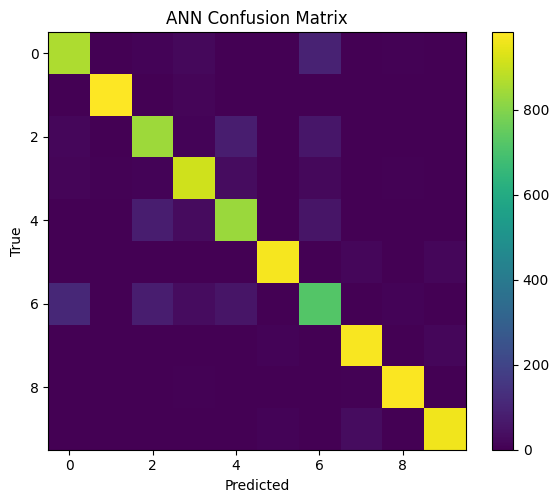

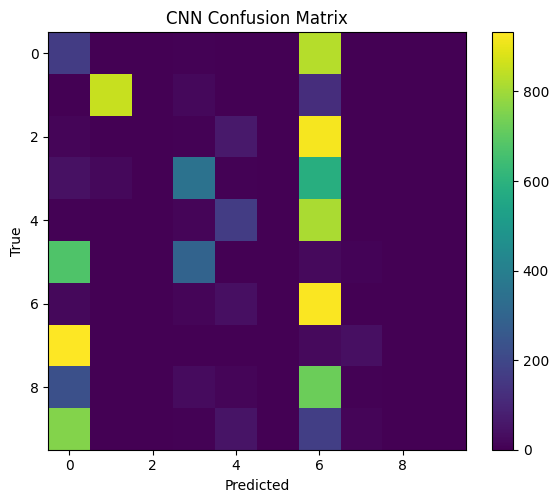

In [10]:
def evaluate(model, name):
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"{name} — Test accuracy: {test_acc:.4f}")

    # preds for CM
    y_true = y_test
    y_pred = np.concatenate([np.argmax(model.predict(bx, verbose=0), axis=1) for bx,_ in test_ds])
    cm = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=class_names))
    return cm

cm_ann = evaluate(ann, "ANN")
cm_cnn = evaluate(cnn, "CNN")

def plot_cm(cm, title):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar(); plt.tight_layout(); plt.show()

plot_cm(cm_ann, "ANN Confusion Matrix")
plot_cm(cm_cnn, "CNN Confusion Matrix")


In [1]:
# 1) Clean imports + force CPU + float32 (avoid Metal issues during convert)
import os, tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.keras.mixed_precision.set_global_policy("float32")
tf.config.set_visible_devices([], "GPU")  # disable Metal for this step only

from tensorflow import keras

# 2) Load your best model
best_cnn = keras.models.load_model("best_cnn.keras")

# 3) Export to SavedModel (works with Keras 3 / TF 2.16+)
# If this line errors, use the fallback two lines below it.
try:
    best_cnn.export("sm_cnn")          # Keras 3 API
except Exception:
    tf.saved_model.save(best_cnn, "sm_cnn")  # fallback

# 4) Convert from SavedModel on CPU
converter = tf.lite.TFLiteConverter.from_saved_model("sm_cnn")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]  # pure TFLite ops
tflite_model = converter.convert()

with open("fashion_cnn.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved: fashion_cnn.tflite")


INFO:tensorflow:Assets written to: sm_cnn/assets


INFO:tensorflow:Assets written to: sm_cnn/assets


Saved artifact at 'sm_cnn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  6399688048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6399687696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6399687872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6403375872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6403375520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6403376048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6403375696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6403376576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6403376400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6403376224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6403376928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  640337710

W0000 00:00:1762269681.190730  194554 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.


Saved: fashion_cnn.tflite


W0000 00:00:1762269681.191153  194554 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


In [8]:
from tensorflow import keras

cnn = keras.models.load_model("best_cnn.keras")
print("CNN model loaded ✅")


CNN model loaded ✅


✅ CNN model loaded
✅ Test data loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


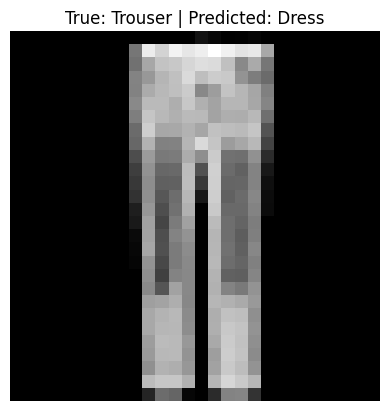

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


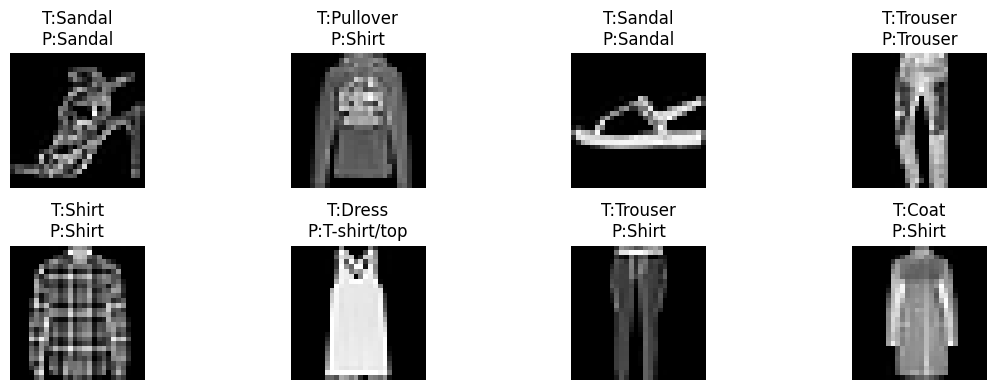

In [11]:
# ====== IMPORTS ======
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# ====== LOAD MODEL ======
cnn = keras.models.load_model("best_cnn.keras")
print("✅ CNN model loaded")

# ====== LOAD DATA (same as you saved earlier) ======
# ⚠️ If you already have x_test, skip this part.
# Use DATA_DIR path you used for your project

from pathlib import Path
import gzip

DATA_DIR = Path.cwd() / "data" / "fashion"

FILES = {
    "train_images": DATA_DIR / "train-images-idx3-ubyte.gz",
    "train_labels": DATA_DIR / "train-labels-idx1-ubyte.gz",
    "test_images":  DATA_DIR / "t10k-images-idx3-ubyte.gz",
    "test_labels":  DATA_DIR / "t10k-labels-idx1-ubyte.gz",
}

DTYPE_MAP = {0x08: np.uint8}

def read_idx_gz(path):
    with gzip.open(path, "rb") as f:
        zero1, zero2, dtype, ndim = f.read(4)
        shape = tuple(int.from_bytes(f.read(4), "big") for _ in range(ndim))
        return np.frombuffer(f.read(), dtype=DTYPE_MAP[dtype]).reshape(shape)

x_test = read_idx_gz(FILES["test_images"])
y_test = read_idx_gz(FILES["test_labels"])

# Preprocess same as training
x_test = (x_test.astype("float32") / 255.0)[..., None]

# ====== CLASS NAMES ======
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

print("✅ Test data loaded")

# ====== SINGLE IMAGE PREDICTION ======
i = 15  # change index
pred = np.argmax(cnn.predict(x_test[i:i+1]), axis=1)[0]

plt.imshow(x_test[i].squeeze(), cmap="gray")
plt.title(f"True: {class_names[y_test[i]]} | Predicted: {class_names[pred]}")
plt.axis('off')
plt.show()

# ====== MULTIPLE RANDOM PREDICTIONS ======
import random
plt.figure(figsize=(12,4))

for idx, j in enumerate(random.sample(range(len(x_test)), 8)):
    pred = np.argmax(cnn.predict(x_test[j:j+1]), axis=1)[0]
    plt.subplot(2,4,idx+1)
    plt.imshow(x_test[j].squeeze(), cmap='gray')
    plt.title(f"T:{class_names[y_test[j]]}\nP:{class_names[pred]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
